In [54]:
import os
import random
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import keras
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import sys
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, Activation
from keras.layers import SeparableConv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

Let's see how many photos we have to train, test and validate our model.

In [55]:
train_folder= r"C:\Users\meiza\Documents\GitHub\CNN-Pneumonia\chest_xray\train"
val_folder = r"C:\Users\meiza\Documents\GitHub\CNN-Pneumonia\chest_xray\val"
test_folder = r"C:\Users\meiza\Documents\GitHub\CNN-Pneumonia\chest_xray\test"

train_normal_folder= r"C:\Users\meiza\Documents\GitHub\CNN-Pneumonia\chest_xray\train\NORMAL"
val_normal_folder = r"C:\Users\meiza\Documents\GitHub\CNN-Pneumonia\chest_xray\val\NORMAL"
test_normal_folder = r"C:\Users\meiza\Documents\GitHub\CNN-Pneumonia\chest_xray\test\NORMAL"

train_pneumonia_folder= r"C:\Users\meiza\Documents\GitHub\CNN-Pneumonia\chest_xray\train\PNEUMONIA"
val_pneumonia_folder = r"C:\Users\meiza\Documents\GitHub\CNN-Pneumonia\chest_xray\val\PNEUMONIA"
test_pneumonia_folder = r"C:\Users\meiza\Documents\GitHub\CNN-Pneumonia\chest_xray\test\PNEUMONIA"

print(len(os.listdir(train_normal_folder)))
print(len(os.listdir(val_normal_folder)))
print(len(os.listdir(test_normal_folder)))
print(len(os.listdir(train_pneumonia_folder)))
print(len(os.listdir(val_pneumonia_folder)))
print(len(os.listdir(test_pneumonia_folder)))

1341
8
234
3875
8
390


We create the model composed of convolution, max pooling, flatten, and dense layers.

In [56]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 2 , activation = 'softmax'))
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_24 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 38, 38, 64)       

Next step consists in generating and transforming our dataset to fit it to our model.

In [57]:
    train_datagen = ImageDataGenerator(
        rescale=1/255,
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False)

val_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
                                                    train_folder,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    classes=['NORMAL', 'PNEUMONIA'])

val_generator = val_datagen.flow_from_directory(
                                                    val_folder,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    classes=['NORMAL', 'PNEUMONIA'])
    
test_generator = test_datagen.flow_from_directory(
                                                    test_folder,
                                                    target_size=(150, 150),
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    classes=['NORMAL', 'PNEUMONIA'])


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Let's train our model.

In [58]:
history = model.fit(train_generator,
                    epochs=12,
                    verbose=1,
                    validation_data=val_generator,
                    class_weight={0:1.0, 1:0.4},
                    callbacks=[learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 179s 1s/step - loss: 0.2852 - accuracy: 0.8602 - val_loss: 19.0281 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 173s 1s/step - loss: 0.1394 - accuracy: 0.9051 - val_loss: 11.9024 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9206
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 173s 1s/step - loss: 0.1188 - accuracy: 0.9206 - val_loss: 11.1925 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - 176s 1s/step - loss: 0.0917 - accuracy: 0.9411 - val_loss: 4.3799 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9373
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [==============================] - 176s 1s/step - loss: 0.0923 - accuracy: 0

Let's take a look at the following graphs. We can see that the more epochs we run the more accuracy we achieve.

<Figure size 432x288 with 0 Axes>

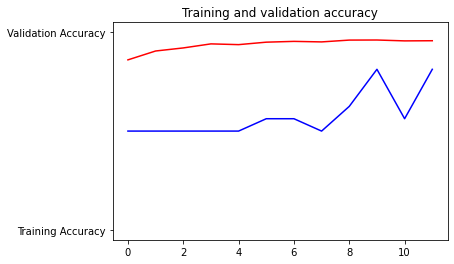

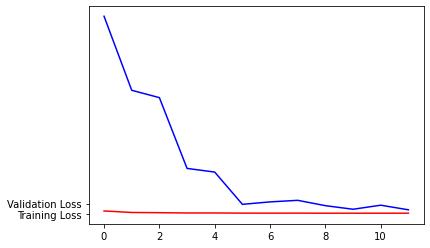

<Figure size 432x288 with 0 Axes>

In [59]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()



plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

Now it's time to calculate the accuracy with test dataset.

In [60]:
print("Loss of the model is - " , model.evaluate(test_generator)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(test_generator)[1]*100 , "%")

624/624 [==============================] - 9s 14ms/step - loss: 0.2600 - accuracy: 0.9071
Loss of the model is -  26.001664996147156 %
624/624 [==============================] - 9s 14ms/step - loss: 0.2600 - accuracy: 0.9071
Accuracy of the model is -  90.70512652397156 %


Once we get our expected model, we save it to avoid having to train it again.

In [61]:
model.save('model.h5')

Finally, let's have a look at Confusion matrix and classification report.

In [62]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')

target_names = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[197  37]
 [ 21 369]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.90      0.84      0.87       234
   Pneumonia       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624

